In [3]:
import pyximport
import numpy as np
pyximport.install(setup_args={"include_dirs": np.get_include()},
                  reload_support=True)
from algorithms.knn_neighborhood import UserKNN
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict, Counter
from datetime import datetime as dt
from scipy.stats import spearmanr

In [10]:
def get_anonymity_matrix(model, item_ratings):
    anonymity_set_sizes = np.ones((model.trainset.n_users, model.trainset.n_users)) * np.inf
    for alice in model.trainset.all_users():
        d = defaultdict(list)
        for bob, secret in model.known_secrets[alice]:
            d[bob].append(secret)

        for bob, secrets in d.items():
            anonymity_set = set(trainset.all_users())
            for iid in secrets:
                anonymity_set = anonymity_set.intersection(item_ratings[iid])
            anonymity_set_sizes[alice, bob] = len(anonymity_set)
            
    return anonymity_set_sizes
    
def get_avg_anonymity(model, item_ratings):
    anonymity_set_sizes = get_anonymity_matrix(model, item_ratings)
    
    anonymities = np.amin(anonymity_set_sizes, axis=0)
    avg_anonymity = np.mean(anonymities[~np.isinf(anonymities)])
    return avg_anonymity

def get_avg_top_neighbor_anonymity(model, item_ratings):
    n_known_secrets_matrix = np.zeros((trainset.n_users, trainset.n_users))
    for alice in model.trainset.all_users():
        for bob, secret in model.known_secrets[alice]:
            n_known_secrets_matrix[alice, bob] += 1

    top_neighbors = []
    for alice, row in enumerate(n_known_secrets_matrix):
        top_neighbor = np.argmax(row)
        if n_known_secrets_matrix[alice, top_neighbor] > 0:
            top_neighbors.append((alice, top_neighbor))

    anonymity_matrix = get_anonymity_matrix(model, item_ratings)
    top_neighbor_anonymity = []
    for alice, top_neighbor in top_neighbors:
        top_neighbor_anonymity.append(anonymity_matrix[alice, top_neighbor])

    return np.mean(top_neighbor_anonymity)

In [11]:
data_df = pd.read_csv("data/ml-100k/u.data", sep="\t")
data_df.columns = ["user_id", "item_id", "rating", "timestamp"]
data_df.drop(columns=["timestamp"], axis=1, inplace=True)
data_df["user_id"] = data_df["user_id"].map({b: a for a, b in enumerate(data_df["user_id"].unique())})
data_df["item_id"] = data_df["item_id"].map({b: a for a, b in enumerate(data_df["item_id"].unique())})

reader = Reader(rating_scale=(1, 5))
dataset = Dataset.load_from_df(data_df, reader=reader)
#trainset, testset = train_test_split(dataset, test_size=0.2)
folds = KFold(n_splits=5)

In [19]:
userknn, userknnreuse, pop, popreuse, gain, gainreuse = [], [], [], [], [], []
userknntop, userknnreusetop, poptop, popreusetop, gaintop, gainreusetop = [], [], [], [], [], []
Ks = np.arange(1, 31, 2)
for trainset, testset in folds.split(dataset):
    item_ratings = dict()
    for iid, ratings_i in trainset.ir.items():
        item_ratings[iid] = set([uid for uid, _ in ratings_i])
        
    userknn_fold, userknnreuse_fold, pop_fold, popreuse_fold, gain_fold, gainreuse_fold = [], [], [], [], [], []
    userknntop_fold, userknnreusetop_fold, poptop_fold, popreusetop_fold, gaintop_fold, gainreusetop_fold = [], [], [], [], [], []
    for k in Ks:
        print(k)
        model = UserKNN(k=k)
        model.fit(trainset)
        _ = model.test(testset)
        userknn_fold.append(get_avg_anonymity(model, item_ratings))
        userknntop_fold.append(get_avg_top_neighbor_anonymity(model, item_ratings))

        model = UserKNN(k=k, reuse=True)
        model.fit(trainset)
        _ = model.test(testset)
        userknnreuse_fold.append(get_avg_anonymity(model, item_ratings))
        userknnreusetop_fold.append(get_avg_top_neighbor_anonymity(model, item_ratings))

        model = UserKNN(k=k, tau_2=0.5)
        model.fit(trainset)
        _ = model.test(testset)
        pop_fold.append(get_avg_anonymity(model, item_ratings))
        poptop_fold.append(get_avg_top_neighbor_anonymity(model, item_ratings))

        model = UserKNN(k=k, tau_2=0.5, reuse=True)
        model.fit(trainset)
        _ = model.test(testset)
        popreuse_fold.append(get_avg_anonymity(model, item_ratings))
        popreusetop_fold.append(get_avg_top_neighbor_anonymity(model, item_ratings))

        model = UserKNN(k=k, tau_4=0.5)
        model.fit(trainset)
        _ = model.test(testset)
        gain_fold.append(get_avg_anonymity(model, item_ratings))
        gaintop_fold.append(get_avg_top_neighbor_anonymity(model, item_ratings))

        model = UserKNN(k=k, tau_4=0.5, reuse=True)
        model.fit(trainset)
        _ = model.test(testset)
        gainreuse_fold.append(get_avg_anonymity(model, item_ratings))
        gainreusetop_fold.append(get_avg_top_neighbor_anonymity(model, item_ratings))
    
    userknn.append(userknn_fold)
    userknnreuse.append(userknnreuse_fold)
    pop.append(pop_fold)
    popreuse.append(popreuse_fold)
    gain.append(gain_fold)
    gainreuse.append(gainreuse_fold)
    
    userknntop.append(userknntop_fold)
    userknnreusetop.append(userknnreusetop_fold)
    poptop.append(poptop_fold)
    popreusetop.append(popreusetop_fold)
    gaintop.append(gaintop_fold)
    gainreusetop.append(gainreusetop_fold)
    
    print("fold finished")
    
userknn = np.mean(userknn, axis=0)
userknnreuse = np.mean(userknnreuse, axis=0)
pop = np.mean(pop, axis=0)
popreuse = np.mean(popreuse, axis=0)
gain = np.mean(gain, axis=0)
gainreuse = np.mean(gainreuse, axis=0)

userknntop = np.mean(userknntop, axis=0)
userknnreusetop = np.mean(userknnreusetop, axis=0)
poptop = np.mean(poptop, axis=0)
popreusetop = np.mean(popreusetop, axis=0)
gaintop = np.mean(gaintop, axis=0)
gainreusetop = np.mean(gainreusetop, axis=0)

1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
fold finished
1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
fold finished
1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
fold finished
1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
fold finished
1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
fold finished


In [20]:
%matplotlib qt

In [21]:
plt.figure()
plt.plot(Ks, userknn, color="C0", linestyle="dashed", label="UserKNN", alpha=0.5)
plt.plot(Ks, pop, color="C1", linestyle="dashed", label="Popularity", alpha=0.5)
plt.plot(Ks, gain, color="C2", linestyle="dashed", label="Gain", alpha=0.5)
plt.plot(Ks, userknnreuse, color="C0", linestyle="solid", label="UserKNN + Reuse")
plt.plot(Ks, popreuse, color="C1", linestyle="solid", label="Popularity + Reuse")
plt.plot(Ks, gainreuse, color="C2", linestyle="solid", label="Gain + Reuse")
plt.xlabel("Nr. of neighbors")
plt.ylabel("Avg. anonymity")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

In [22]:
plt.figure()
plt.plot(Ks, userknntop, color="C0", linestyle="dashed", label="UserKNN", alpha=0.5)
plt.plot(Ks, poptop, color="C1", linestyle="dashed", label="Popularity", alpha=0.5)
plt.plot(Ks, gaintop, color="C2", linestyle="dashed", label="Gain", alpha=0.5)
plt.plot(Ks, userknnreusetop, color="C0", linestyle="solid", label="UserKNN + Reuse")
plt.plot(Ks, popreusetop, color="C1", linestyle="solid", label="Popularity + Reuse")
plt.plot(Ks, gainreusetop, color="C2", linestyle="solid", label="Gain + Reuse")
plt.xlabel("Nr. of neighbors")
plt.ylabel("Avg. anonymity of top neighbors")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

In [ ]:
userknn, userknnreuse, pop, popreuse, gain, gainreuse

In [ ]:
userknntop, userknnreusetop, poptop, popreusetop, gaintop, gainreusetop

In [228]:
model = UserKNN(k=10)
model.fit(trainset)
_ = model.test(testset)

n_known_secrets_matrix = np.zeros((trainset.n_users, trainset.n_users))
for alice in model.trainset.all_users():
    for bob, secret in model.known_secrets[alice]:
        n_known_secrets_matrix[alice, bob] += 1

top_neighbors = []
for alice, row in enumerate(n_known_secrets_matrix):
    top_neighbor = np.argmax(row)
    if n_known_secrets_matrix[alice, top_neighbor] > 0:
        top_neighbors.append((alice, top_neighbor))

anonymity_matrix = get_anonymity_matrix(model)
top_neighbor_anonymity = []
for alice, top_neighbor in top_neighbors:
    top_neighbor_anonymity.append(anonymity_matrix[alice, top_neighbor])

userknn_top_neighbor_anonymity = top_neighbor_anonymity

In [23]:
model = UserKNN(k=10, reuse=True, tau_4=0.5)
model.fit(trainset)
_ = model.test(testset)

n_known_secrets_matrix = np.zeros((trainset.n_users, trainset.n_users))
for alice in model.trainset.all_users():
    for bob, secret in model.known_secrets[alice]:
        n_known_secrets_matrix[alice, bob] += 1

top_neighbors = []
for alice, row in enumerate(n_known_secrets_matrix):
    top_neighbor = np.argmax(row)
    if n_known_secrets_matrix[alice, top_neighbor] > 0:
        top_neighbors.append((alice, top_neighbor))

anonymity_matrix = get_anonymity_matrix(model)
top_neighbor_anonymity = []
for alice, top_neighbor in top_neighbors:
    top_neighbor_anonymity.append(anonymity_matrix[alice, top_neighbor])

KeyboardInterrupt: 

(array([  1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   1.,   1.,
          1.,   1.,   2.,   8.,   6.,  22.,  21.,  29.,  60., 104., 668.,
         13.,   1.,   1.]),
 array([-341. , -325.4, -309.8, -294.2, -278.6, -263. , -247.4, -231.8,
        -216.2, -200.6, -185. , -169.4, -153.8, -138.2, -122.6, -107. ,
         -91.4,  -75.8,  -60.2,  -44.6,  -29. ,  -13.4,    2.2,   17.8,
          33.4,   49. ]),
 <BarContainer object of 25 artists>)

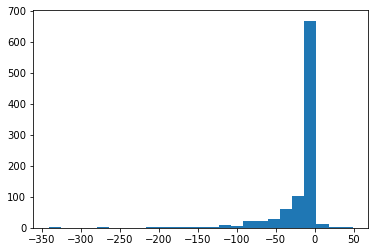

In [248]:
diffs = np.array(top_neighbor_anonymity) - np.array(userknn_top_neighbor_anonymity)
plt.hist(diffs, bins=25)

In [250]:
np.mean(top_neighbor_anonymity)

6.348195329087049

In [257]:
(diffs >= -58).sum() / model.trainset.n_users

0.9247083775185578

In [24]:
model = UserKNN(k=10)
model.fit(trainset)
_ = model.test(testset)

n_known_secrets_matrix = np.zeros((trainset.n_users, trainset.n_users))
for alice in model.trainset.all_users():
    for bob, secret in model.known_secrets[alice]:
        n_known_secrets_matrix[alice, bob] += 1

top_neighbors = []
for alice, row in enumerate(n_known_secrets_matrix):
    top_neighbor = np.argmax(row)
    if n_known_secrets_matrix[alice, top_neighbor] > 0:
        top_neighbors.append((alice, top_neighbor))

In [25]:
top_neighbors

[(0, 5),
 (1, 571),
 (2, 248),
 (3, 301),
 (4, 553),
 (5, 248),
 (6, 51),
 (7, 88),
 (8, 363),
 (9, 690),
 (10, 11),
 (11, 452),
 (12, 542),
 (13, 423),
 (14, 93),
 (15, 363),
 (16, 452),
 (17, 242),
 (18, 93),
 (19, 0),
 (20, 11),
 (21, 8),
 (22, 155),
 (23, 567),
 (24, 232),
 (25, 814),
 (26, 88),
 (27, 0),
 (28, 585),
 (29, 291),
 (30, 16),
 (31, 386),
 (32, 439),
 (33, 230),
 (34, 571),
 (35, 501),
 (36, 571),
 (37, 141),
 (38, 116),
 (39, 240),
 (40, 65),
 (41, 249),
 (42, 501),
 (43, 173),
 (44, 196),
 (45, 585),
 (46, 0),
 (47, 7),
 (48, 2),
 (49, 193),
 (50, 104),
 (51, 15),
 (52, 369),
 (53, 51),
 (54, 800),
 (55, 122),
 (56, 15),
 (57, 15),
 (58, 527),
 (59, 8),
 (60, 16),
 (61, 59),
 (62, 402),
 (63, 58),
 (64, 165),
 (65, 240),
 (66, 407),
 (67, 216),
 (68, 122),
 (69, 15),
 (70, 317),
 (71, 660),
 (72, 306),
 (73, 163),
 (74, 270),
 (75, 183),
 (76, 248),
 (77, 10),
 (78, 364),
 (79, 93),
 (80, 187),
 (81, 353),
 (82, 196),
 (83, 492),
 (84, 270),
 (85, 201),
 (86, 31),
 (